# 0. Meta

## 0.1. Packages

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Matplotlib is building the font cache; this may take a moment.


## 0.2. Functions

In [11]:
# Funktion, um Werte in Float zu konvertieren und Fehler abzufangen
def convert_to_float(value):
    try:
        return float(value)
    except ValueError:
        print(f"Konvertierungsfehler bei: {value}")
        return None

# 1. Data import

In [6]:
file_path = r"C:\Sync\03_projects\data_science\projects\weddingsurvey\Hochzeitsgäste_im_Check.csv"

In [7]:
df = pd.read_csv(file_path)

In [8]:
df.head()

,Teilnehmer,Startzeit,Endzeit,Quelle,Wie alt bist du?,Mit welchem Geschlecht identifizierst du dich?,In welchem Land bist du geboren?,Wie lautet die Postleitzahl (PLZ) deines Wohnortes?,Wie ist dein Familienstand?,Wie viele Kinder hast du?,...,Wer fährt besser Fahrrad nach dem Biergartenbesuch? (Lucas),Wer hat mehr Narben? (Lena),Wer hat mehr Narben? (Lucas),Wer hat nach einem Tag in der Sonne eher die Hautfarbe eines Hummers? (Lena),Wer hat nach einem Tag in der Sonne eher die Hautfarbe eines Hummers? (Lucas),"Welchen Nachnamen soll das Brautpaar wählen, wenn es nach dir geht?",Wer verbringt mehr Zeit am Handy? (Lena),Wer verbringt mehr Zeit am Handy? (Lucas),Wer ist romantischer? (Lena),Wer ist romantischer? (Lucas)
0,1,05.08.2024 08:00:04,05.08.2024 08:03:20,Direkter Link,57,Frau,DE,67435,Verheiratet,5,...,übersprungen,0,1,1,1,Beide sollen ihren aktuellen Nachnamen behalten,1,0,0,1
1,2,05.08.2024 15:03:31,05.08.2024 15:06:48,Direkter Link,34,Mann,Deutschland,67434,Liiert,0,...,1,1,0,1,0,Wallbert-Almann,1,1,0,1
2,3,06.08.2024 13:10:35,06.08.2024 13:16:05,Direkter Link,30,Mann,Deutschland,20099,Liiert,0,...,0,0,1,1,0,Albert-Wallmann,1,0,1,0
3,4,06.08.2024 14:03:29,06.08.2024 14:08:22,Direkter Link,28,Frau,Deutschland,64293,Verheiratet,2,...,1,0,1,1,0,Almann-Wallbert,1,0,0,1
4,5,06.08.2024 14:29:37,06.08.2024 14:38:57,Direkter Link,31,Mann,Deutschland,64293,Verheiratet,2,...,1,0,1,1,0,Albert-Wallmann,1,0,0,1


# 2. Data cleaning

## 2.1 Wie alt bist du?

In [20]:
df['Wie alt bist du? (float)'] = df['Wie alt bist du?'].apply(convert_to_float)
invalid_entries = df[df['Wie alt bist du? (float)'].isnull()]['Wie alt bist du?']
invalid_entries

Konvertierungsfehler bei: 78 Jahre 


11          NaN
46    78 Jahre 
Name: Wie alt bist du?, dtype: object

In [23]:
# Ersetze den ersten ungültigen Eintrag mit NaN
df.loc[invalid_entries.index[0], 'Wie alt bist du?'] = np.nan

# Ersetze den zweiten ungültigen Eintrag mit 78
df.loc[invalid_entries.index[1], 'Wie alt bist du?'] = 78

In [27]:
# Konvertierung in float vornehmen
df['Wie alt bist du? (float)'] = df['Wie alt bist du?'].apply(convert_to_float)

# Überprüfen, ob die Änderungen korrekt sind
df[['Wie alt bist du?', 'Wie alt bist du? (float)']].loc[invalid_entries.index]

,Wie alt bist du?,Wie alt bist du? (float)
11,NaN,NaN
46,78,78.0


In [31]:
# Berechnung der statistischen Kennzahlen für die Altersvariable
summary_stats = {
    'Min': df['Wie alt bist du? (float)'].min(),
    'Max': df['Wie alt bist du? (float)'].max(),
    'Mean': df['Wie alt bist du? (float)'].mean(),
    'SD': df['Wie alt bist du? (float)'].std()
}

print("Zusammenfassung der Altersdaten:")
summary_stats

Zusammenfassung der Altersdaten:


{'Min': np.float64(21.0),
 'Max': np.float64(80.0),
 'Mean': np.float64(36.224489795918366),
 'SD': np.float64(13.50503811256261)}

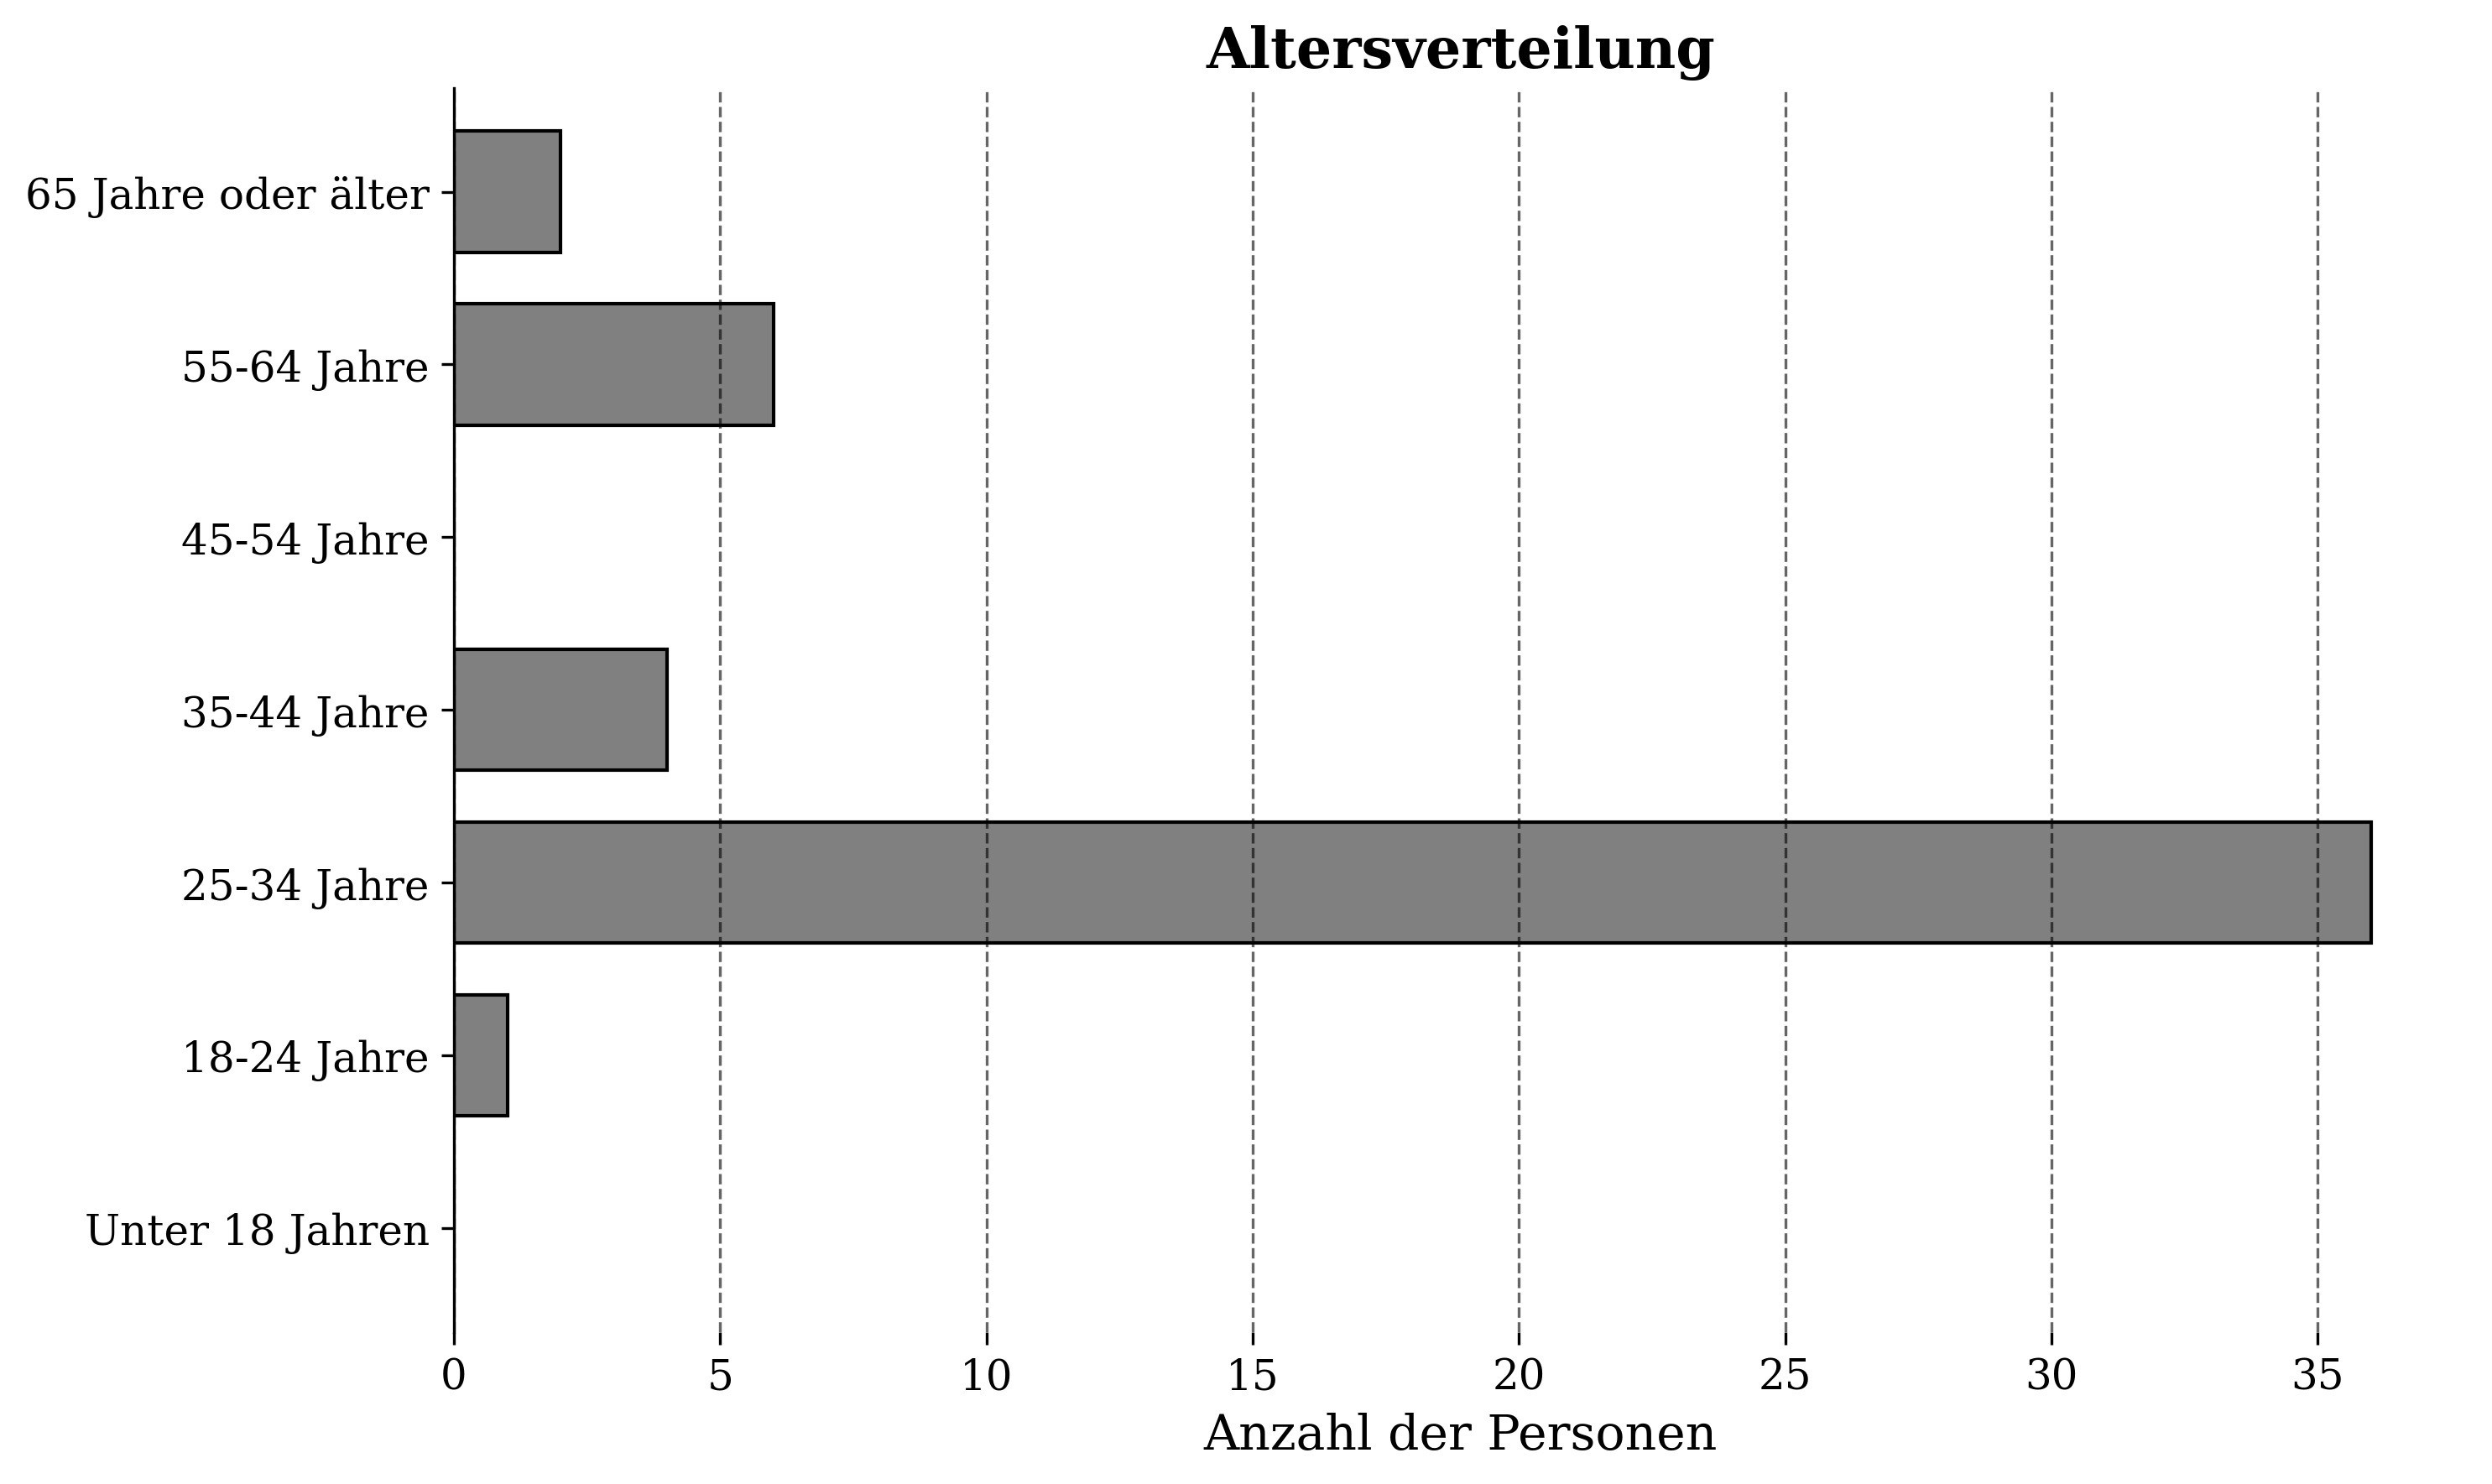

In [41]:
# Erstelle das horizontale Balkendiagramm der Altersgruppen
plt.figure(figsize=(10, 6), dpi=300)
age_group_counts.plot(kind='barh', color='gray', edgecolor='black', width=0.7)  # Verkleinere den Abstand zwischen den Balken durch Setzen der Breite
plt.title('Altersverteilung', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Anzahl der Personen', fontsize=14, family='serif')
plt.xticks(fontsize=12, family='serif')
plt.yticks(fontsize=12, family='serif')
plt.grid(axis='x', linestyle='--', alpha=0.6, color='black')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.ylabel('')  # Entfernt das y-Label
plt.tight_layout()  # Optimiert den Layout-Abstand
plt.show()

## 2.2 Mit welchem Geschlecht identifizierst du dich?

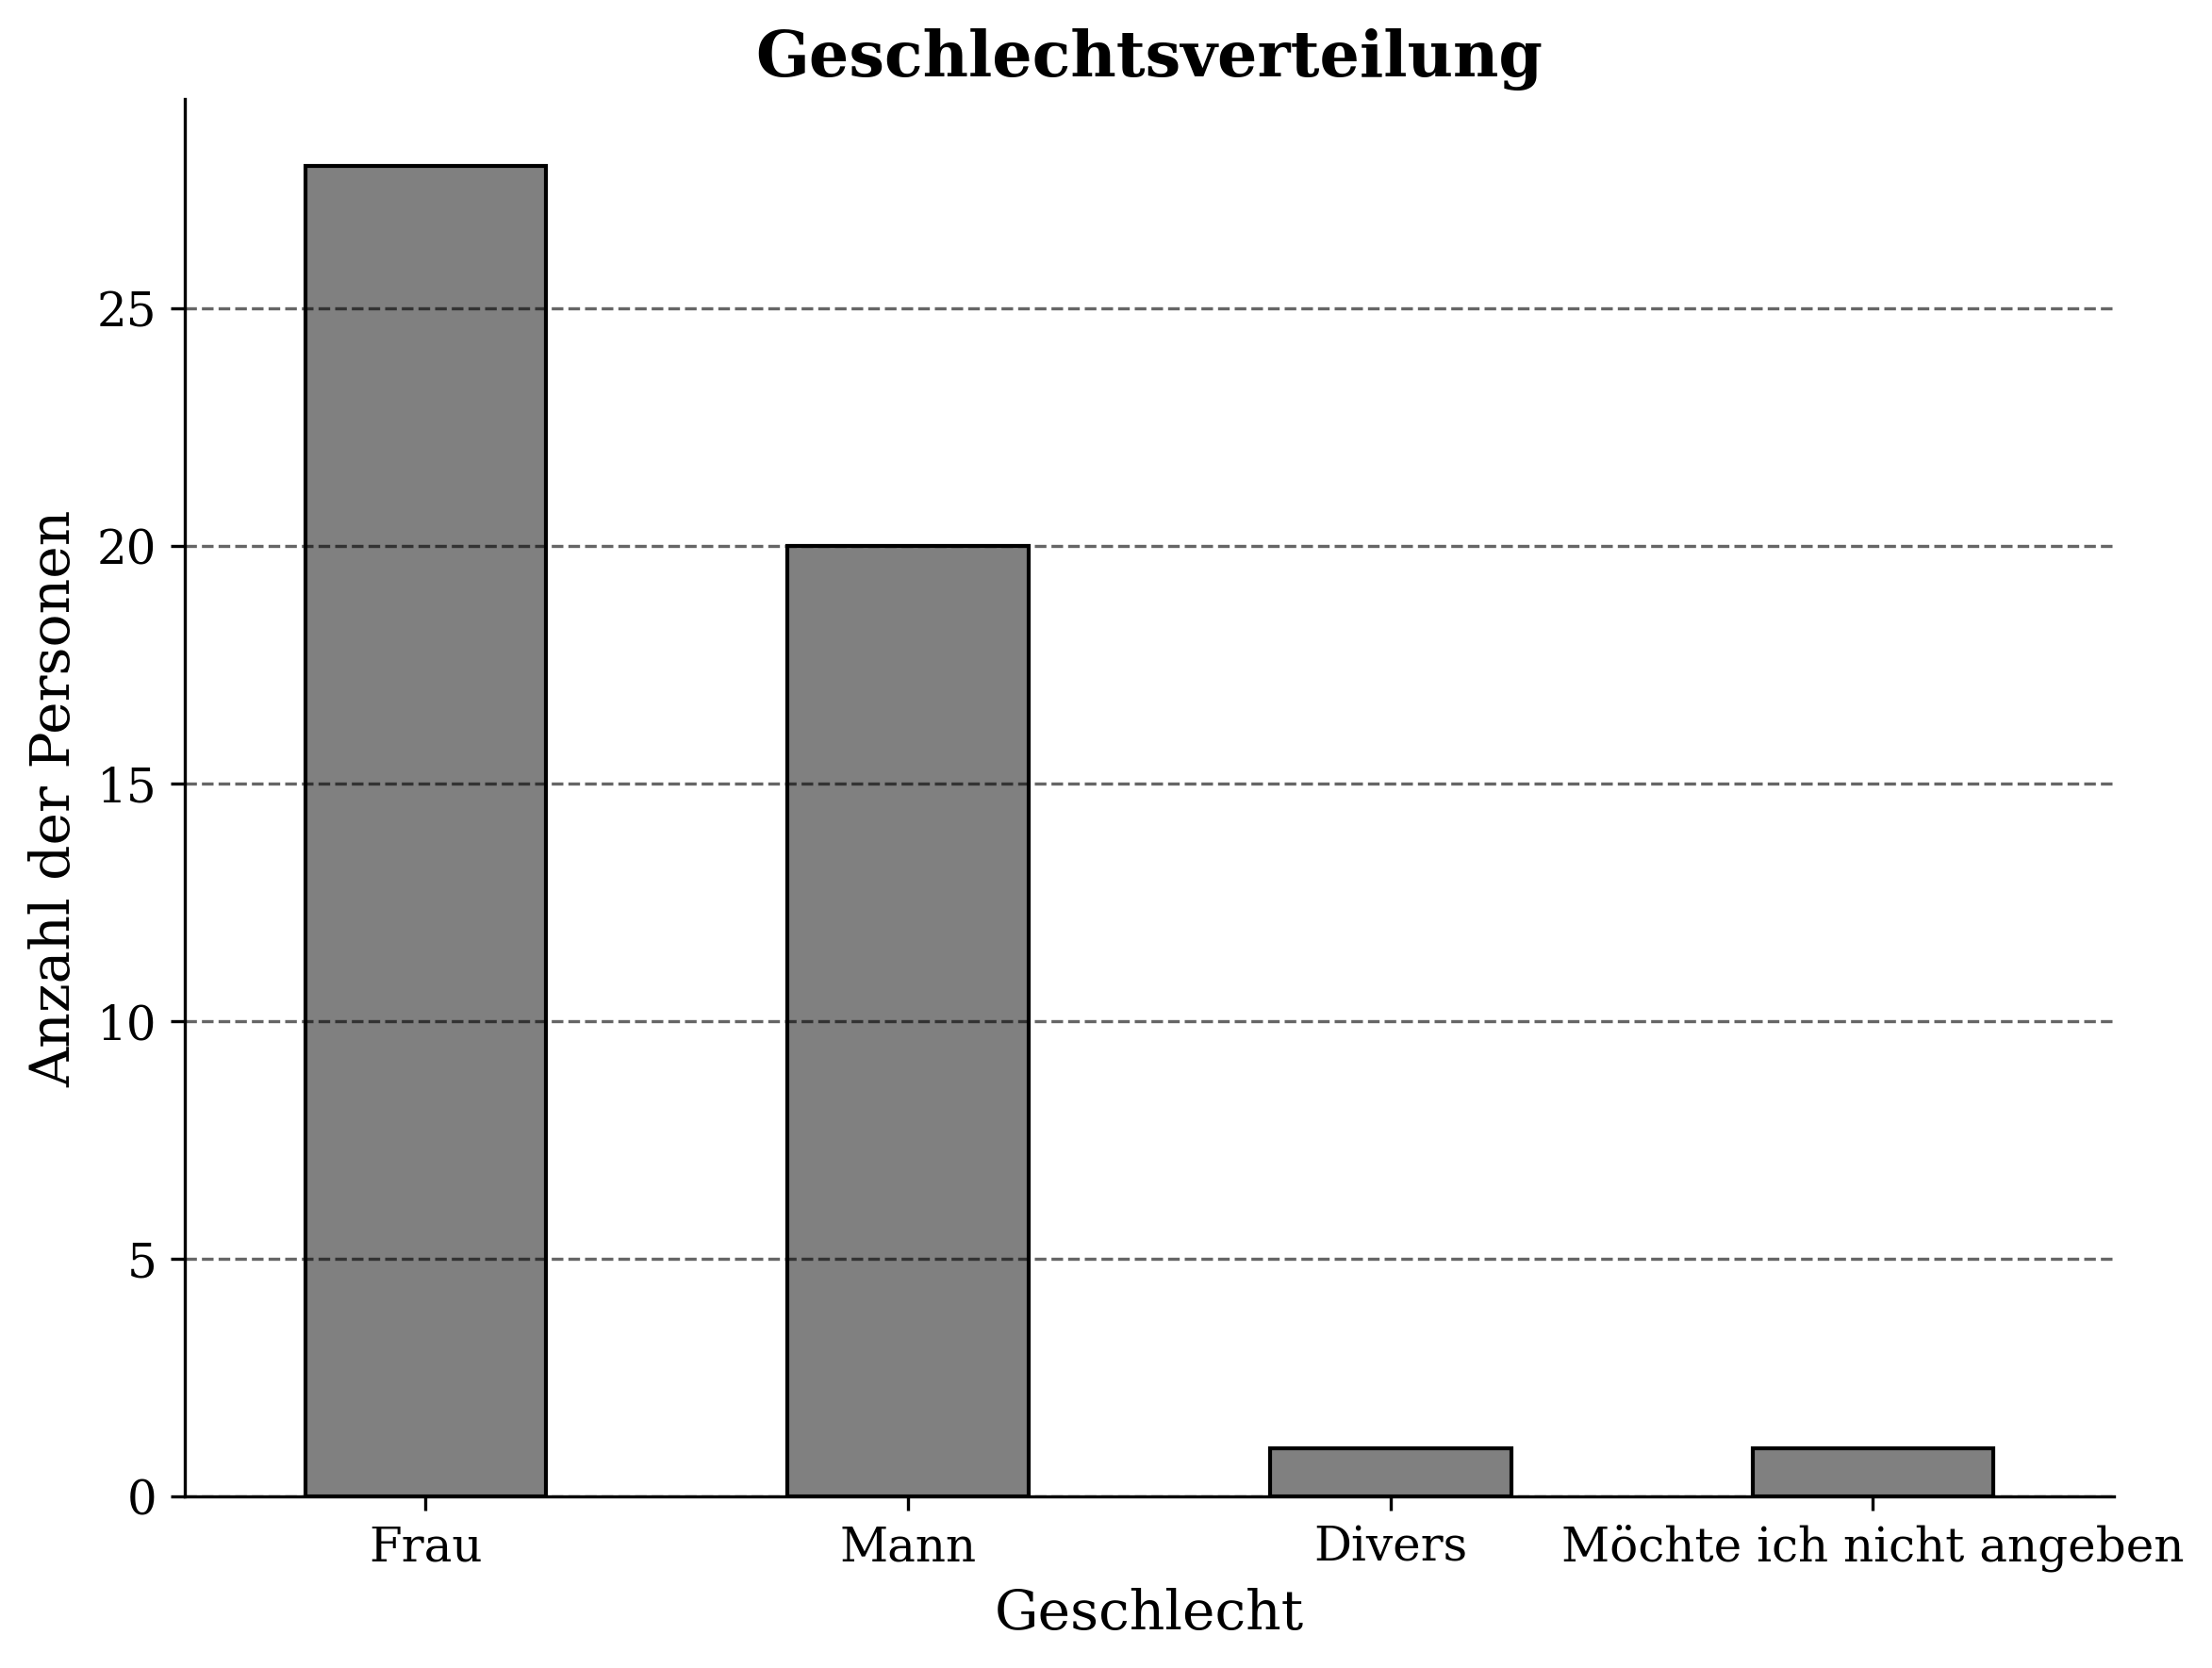

In [42]:
# Berechne die Häufigkeit der Antworten
gender_counts = df['Mit welchem Geschlecht identifizierst du dich?'].value_counts()

# Erstelle ein Balkendiagramm der Geschlechtsverteilung
plt.figure(figsize=(8, 6), dpi=300)
gender_counts.plot(kind='bar', color='gray', edgecolor='black')
plt.title('Geschlechtsverteilung', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Geschlecht', fontsize=14, family='serif')
plt.ylabel('Anzahl der Personen', fontsize=14, family='serif')
plt.xticks(rotation=0, fontsize=12, family='serif')
plt.yticks(fontsize=12, family='serif')
plt.grid(axis='y', linestyle='--', alpha=0.6, color='black')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()  # Optimiert den Layout-Abstand
plt.show()